
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Grid Search Intervention

In [1]:
#@title Import libraries
import transformer_lens
import torch, gc, itertools, tqdm, scipy, functools, collections, copy
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import localizing, modelHandlers, dataLoaders, gradient, intervening

## Model and Data

In [2]:
model = modelHandlers.load_model(model_type="gpt-neo-125M", DEVICE="cpu", lr=0.001, weight_decay=0)

Loaded pretrained model gpt-neo-125M into HookedTransformer
added optimizer with lr: 0.001 and weight_decay: 0
setting no_grad on ['embed', 'pos_embed', 'unembed']


In [3]:
train_dl, test_dl = dataLoaders.batched_pile(mem_batch=10, non_mem_batch=10, test_frac=0.0, set_twice=None)
#dl = dataLoaders.batched_pop_seqs(model, mem_batch=5, non_mem_batch=10)

## Run Model and Collect Gradients 

In [4]:
c_types= ["W_Q","W_K","W_V","W_O","W_in","W_out"]
fwd_bwd = functools.partial(gradient.contrast_metric, I_range=[50,51], with_mse=True, pool={"c":[-1],"k":[0,-1]}, norm_sets=1.0, only_set=None)
c_weights = localizing.batched_c_type_collection(model, train_dl, fwd_bwd, c_types=c_types, n_batches=1)

0it [00:00, ?it/s]

contrast_res: 0.0, c_nll: 0.0, k_nll: 0.0


0it [00:16, ?it/s]

returning ['blocks.0.attn.W_Q', 'blocks.1.attn.W_Q']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_K', 'blocks.1.attn.W_K']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_V', 'blocks.1.attn.W_V']... of shape: torch.Size([12, 12, 768, 64])
returning ['blocks.0.attn.W_O', 'blocks.1.attn.W_O']... of shape: torch.Size([12, 12, 64, 768])
returning ['blocks.0.mlp.W_in', 'blocks.1.mlp.W_in']... of shape: torch.Size([12, 768, 3072])
returning ['blocks.0.mlp.W_out', 'blocks.1.mlp.W_out']... of shape: torch.Size([12, 3072, 768])


In [5]:
def intervention_grid(model, dl, n_batch:int=1, decode_k:bool=True, c_weights:dict={}, topK_space:tuple=(0,10,5), val_space:tuple=(0,3,1), select_c:list=[], select_l:list=[], select_heads:list=[], largest:bool=True):
    """
    searching for best intervention setting by iterating over ideal intervention values
    """
    intervene_vals = torch.linspace(val_space[0], val_space[1], steps=val_space[2])
    topK_vals = torch.linspace(topK_space[0], topK_space[1], steps=topK_space[2]) 
    print(f"searching over {len(intervene_vals)*len(topK_vals)} different topK and val settings")
    ck_em, ck_nll = torch.zeros(len(topK_vals), len(intervene_vals),2),torch.zeros(len(topK_vals), len(intervene_vals),2)
    
    if decode_k: ## get predictions on k without intervention
        k_preds_orig, _ = modelHandlers.batch_decode(model, toks_NI=None, dl=train_dl, n_batch=n_batch)
    
    for i, topK_val in tqdm.tqdm(enumerate(topK_vals)):
        for j, intervene_val in enumerate(intervene_vals):
            c_weights_lk = intervening.get_topK_grads(c_weights,topK=int(topK_val),select_c=select_c,select_l=select_l,select_heads=select_heads,return_lk=True,largest=largest,select_random=False)
            model = intervening.intervene_params(model, c_weights_lk, std=intervene_val)
            (c_em, k_em), (c_nll, k_nll) = intervening.evaluate_model(model, dl=dl)
            
            if decode_k: ## compare against decoding on keep set
                k_pred_intervened, _ = modelHandlers.batch_decode(model, toks_NI=None, dl=dl, n_batch=n_batch)
                k_em = modelHandlers.compute_exact_match(k_pred_intervened, k_preds_orig).mean()

            ck_em[i,j,:] = torch.tensor([c_em, k_em])
            ck_nll[i,j,:] = torch.tensor([c_nll, k_nll])
    return ck_em, ck_nll, topK_vals, intervene_vals

n_batch, decode_k, topK_space, val_space, select_c, select_l, select_heads = 1, True, (1,40,3), (0,2,4), ["W_V"], [2], [11]
ck_em, ck_nll, topK_vals, intervene_vals = intervention_grid(model, train_dl, n_batch, decode_k, c_weights, topK_space=topK_space, val_space=val_space, select_c=select_c, select_l=select_l, select_heads=select_heads)

searching over 12 different topK and val settings


0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:02, ?it/s]

KeyboardInterrupt



In [6]:
def change_keep_metric(ck_em:torch.tensor, ck_nll:torch.tensor):
    """
    computing change metric on em and nll
    """
    c_em, k_em = ck_em[...,0], ck_em[...,1] 
    c_nll, k_nll = ck_nll[...,0], ck_nll[...,1]
    ## dim 0: number of weights, dim 1: noise value

    ## exact match
    c_em_mse = (0 - c_em[:,1:])**2
    k_em_mse = (50 - k_em[:,1:])**2
    em_mse = c_em_mse + k_em_mse
    
    ## nll match
    relu = torch.nn.ReLU()
    k_nll_mse = (k_nll[0,0] - k_nll[:,1:])**2 ## any change is bad
    nll_mse = torch.abs(-c_nll[:,1:] + k_nll_mse)
    return em_mse, nll_mse
   
em_mse, nll_mse = change_keep_metric(ck_em, ck_nll)  

Text(0.5, -1.3885555555555538, 'std noise')

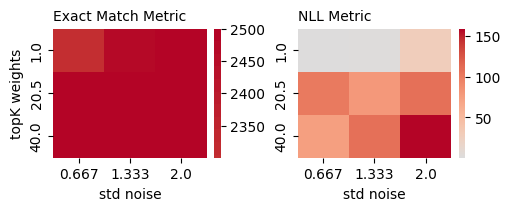

In [7]:
fontsize = 10
fig, axs = plt.subplots(1, 2, figsize=(5, 2), gridspec_kw={'hspace': 1.2}, constrained_layout=True)
axs[0].set_title(f"Exact Match Metric", fontsize=fontsize, loc="left")
axs[1].set_title(f"NLL Metric", fontsize=fontsize, loc="left")

y = list(map(lambda x: round(x, 3), topK_vals.tolist()))
x = list(map(lambda x: round(x, 3), intervene_vals.tolist()[1:]))

metrics = [em_mse, nll_mse]
sns.heatmap(em_mse,cmap=mpl.colormaps["coolwarm"],ax=axs[0], center=0,xticklabels=x,yticklabels=y,square=False)
sns.heatmap(nll_mse,cmap=mpl.colormaps["coolwarm"],ax=axs[1], center=0,xticklabels=x,yticklabels=y,square=False)

axs[0].set_ylabel(f"topK weights", fontsize=fontsize)
axs[0].set_xlabel(f"std noise", fontsize=fontsize)
axs[1].set_xlabel(f"std noise", fontsize=fontsize)


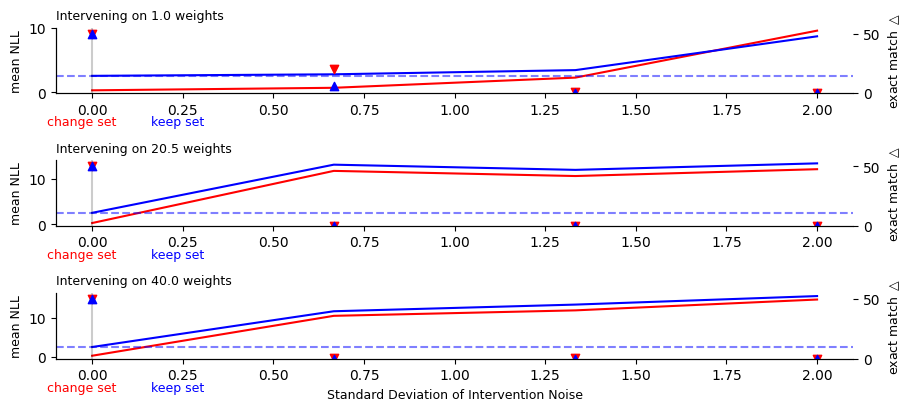

In [8]:
fontsize = 9
fig, axs = plt.subplots(ck_em.shape[0], 1, figsize=(9, 4), gridspec_kw={'wspace': 0.6}, constrained_layout=True)

for i, ax in enumerate(axs):
    c_nll, = ax.plot(intervene_vals, ck_nll[i,:,0].numpy(), c="red", label="change set")
    k_nll, = ax.plot(intervene_vals, ck_nll[i,:,1].numpy(), c="blue", label="keep set")
    ax.axhline(y=ck_nll[i,0,1], color='r', linestyle='--', c="blue", alpha=0.5)

    ax2 = ax.twinx()
    c_em = ax2.scatter(intervene_vals, ck_em[i,:,0].numpy(), c="red", marker="v", label="change set em")
    k_em = ax2.scatter(intervene_vals, ck_em[i,:,1].numpy(), c="blue", marker="^", label="keep set em")
    ax.axvline(x=0, color='r', linestyle='-', c="black", alpha=0.2)

    #plot_summary = f"Intervening on top {model.cfg.intervention['n_weights']} max gradient weights {model.cfg.intervention['c_types']}"
    #plot_summary = f"Intervening on top {model.cfg.intervention['n_weights']} max gradient weights {model.cfg.intervention['c_types']} in layers: {', '.join((str(l) for l in model.cfg.intervention['layers']))}"
    ax.set_title(f"Intervening on {topK_vals[i]} weights", fontsize=fontsize, loc="left")
    if i == ck_em.shape[0]-1:
        ax.set_xlabel('Standard Deviation of Intervention Noise', fontsize=fontsize)
    ax.set_ylabel(r'mean NLL', fontsize=fontsize) #\searrow
    ax2.set_ylabel(r'exact match $\triangle$', fontsize=fontsize) #\bullet
    ax2.set_ylim(0,55)
    legend = ax.legend(handles=[c_nll, k_nll], frameon=False, bbox_to_anchor=(0.2, -0.17), ncol=2, prop={'size': fontsize}, handlelength=0)
    for text, color in zip(legend.get_texts(), ["red", "blue"]):
        text.set_color(color) 
    #ax.savefig("...", dpi=200, bbox_inches='tight')